# Alex Dvorak, Project 6, Oct. 16, 2021

In [1]:
# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# Importing General Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() # improved graph backgrounds

# Importing Preprocessing Modules
from sklearn.preprocessing import StandardScaler

# Importing Clustering Modules
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import cdist, pdist

# Importing Visualization
from yellowbrick.cluster import SilhouetteVisualizer
from scipy.cluster.hierarchy import dendrogram

# Importing Metrics
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import cophenet

# Project Information

### Context
AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers.  

Another insight from the market research was that the customers perceive the support services of the bank poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster.  

### Objective
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

### Questions
1. How many clusters are most reasonable for K-means clustering?
2. What features separate the clusters best?
3. What are the characteristics of the different customer groups?

### Data Description
The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

### Data Dictionary
Sl_No: Primary key of the records  
Customer Key: Customer identification number  
Average Credit Limit: Average credit limit of each customer for all credit cards  
Total credit cards: Total number of credit cards possessed by the customer  
Total visits bank: Total number of visits that customer made (yearly) personally to the bank  
Total visits online: Total number of visits or online logins made by the customer (yearly)  
Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)  

In [2]:
cccd = pd.read_excel('Credit Card Customer Data.xlsx') # loading the data set
cccd.head() # quick view of the data

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


### Quick Checks for Erroneous Values

In [3]:
cccd.duplicated().sum() # checking for duplicated rows

0

In [4]:
cccd.info() # checking the datatypes to help identify where erroneous values may be

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


In [5]:
cccd.describe().T # looking at the minimum and maximum values for unreasonable extremes

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


### Notes on quick checks:
There are no duplicate rows so there is no data leakage caused by a duplicate row being in the training and testing data.  
There are also no missing values in any column in the 660 entries of the dataset.  
All datatypes are integers so there are no hidden errors in strings.  

Both the SI_No and Customer Key will not be used in the analysis. However, we want the columns preserved so that business can expand upon the analysis.  

Avg_Credit_Limit ranges from 3,000 to 200,000. This value is the average of the credit card limits, not the sum of the limits so 200,000 seems a little high. However, it is not out of the realm of possibilities if the person is affluent.  

Total_Credit_Cards ranges from 1 to 10 which are reasonable extremes.  

Total_visits_bank ranges from 0 to 5. A total number of 5 visits in a year that customer personally made to the bank seems a little low for the max, but that's the data.  

Total_visits_online ranges from 0 to 15 which are reasonable extremes.  

Total_calls_made ranges from 0 to 10. These are reasonable values for the extremes.  

# Feature Engineering
Let's add a feature showing the total interaction with the bank, adding the Total_visits_bank, Total_visits_online, and Total_calls_made features together.

In [6]:
cccd['Total_interaction'] = cccd['Total_visits_bank'] + cccd['Total_visits_online'] + cccd['Total_calls_made']
    # creates a new feature combining the visits and calls by the customer

# Exploratory Data Analysis

In [7]:
def univariate_numeric(dataset, feature):
    """This function shows the boxplot and distribution plot for a single variable."""
    dist_figure, (boxplt, histplt) = plt.subplots(nrows=2, sharex=True, figsize=(12,8)) #creates subplots sharing the x-axis
    plt.suptitle(f'Distribution of {feature}', fontsize=32) # big title for each variable to separate data
    sns.boxplot(x=dataset[feature], ax=boxplt); # first subplot is a boxplot
    sns.histplot(dataset[feature], ax=histplt); # second subplot is a histogram
    histplt.axvline(dataset[feature].mean(), color='red', linestyle='-') # puts a line for the mean on the histogram
    histplt.axvline(dataset[feature].median(), color='black', linestyle='-') # puts a line for the median on the histogram
    plt.show()
    
    q3 = np.nanpercentile(dataset[feature], 75) # upper quartile, ignoring null values
    q1 = np.nanpercentile(dataset[feature], 25) # lower quartile, ignoring null values
    lower_outliers = dataset[dataset[feature] < (q1 - (q3-q1)*1.5)] # calculates lower outliers
    upper_outliers = dataset[dataset[feature] > q3 + (q3-q1)*1.5] # calculates upper outliers
    print(f'There are {lower_outliers.shape[0]} lower outliers and {upper_outliers.shape[0]} upper outliers.') #shows outliers
    
    print(f'The median of {feature} is {dataset[feature].median()}.') # prints median value
    print(f'The mean of {feature} is {dataset[feature].mean() : .2f}') # prints mean value
    print(f'The lower whisker of {feature} is {q1 - (q3-q1)*1.5}') # prints the lower whisker
    print(f'The upper whisker of {feature} is {q3 + (q3-q1)*1.5}') # prints the upper whisker
    print(f'The minimum of {feature} is {dataset[feature].min()}') # prints minimum value
    print(f'The maximum of {feature} is {dataset[feature].max()}') # prints maximum value
    print(f'The standard deviation of {feature} is {dataset[feature].std() : .2f}') # prints standard deviation
    print('----------------------------------------------------------') # additional separation between variables

In [8]:
var = ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 
       'Total_visits_online', 'Total_calls_made', 'Total_interaction']
    # excluding the Sl_No and Customer Key features

sub_cccd = cccd[var].copy() # creates a deep copy of the variable we want to explore and scale
sub_cccd.head() # quick view to ensure the subset is correct

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Total_interaction
0,100000,2,1,1,0,2
1,50000,3,0,10,9,19
2,50000,7,1,3,4,8
3,30000,5,1,1,4,6
4,100000,6,0,12,3,15


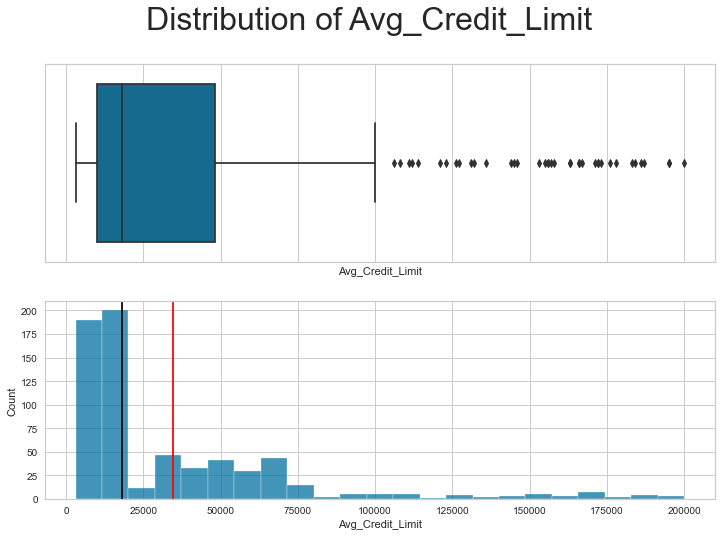

There are 0 lower outliers and 39 upper outliers.
The median of Avg_Credit_Limit is 18000.0.
The mean of Avg_Credit_Limit is  34574.24
The lower whisker of Avg_Credit_Limit is -47000.0
The upper whisker of Avg_Credit_Limit is 105000.0
The minimum of Avg_Credit_Limit is 3000
The maximum of Avg_Credit_Limit is 200000
The standard deviation of Avg_Credit_Limit is  37625.49
----------------------------------------------------------


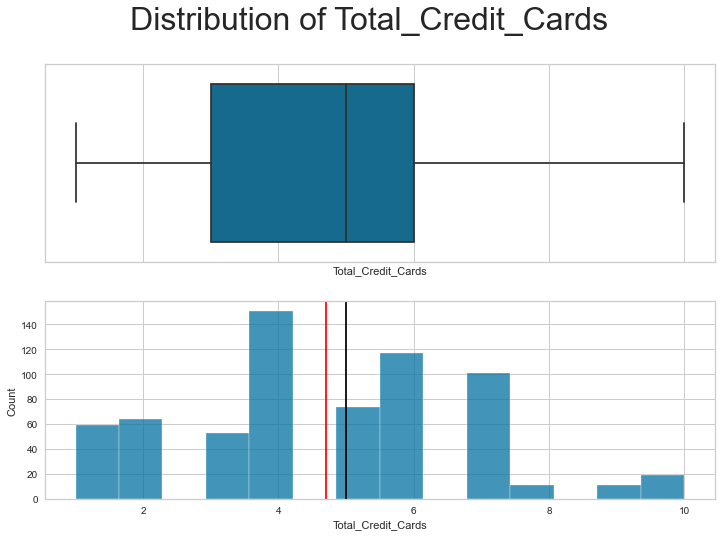

There are 0 lower outliers and 0 upper outliers.
The median of Total_Credit_Cards is 5.0.
The mean of Total_Credit_Cards is  4.71
The lower whisker of Total_Credit_Cards is -1.5
The upper whisker of Total_Credit_Cards is 10.5
The minimum of Total_Credit_Cards is 1
The maximum of Total_Credit_Cards is 10
The standard deviation of Total_Credit_Cards is  2.17
----------------------------------------------------------


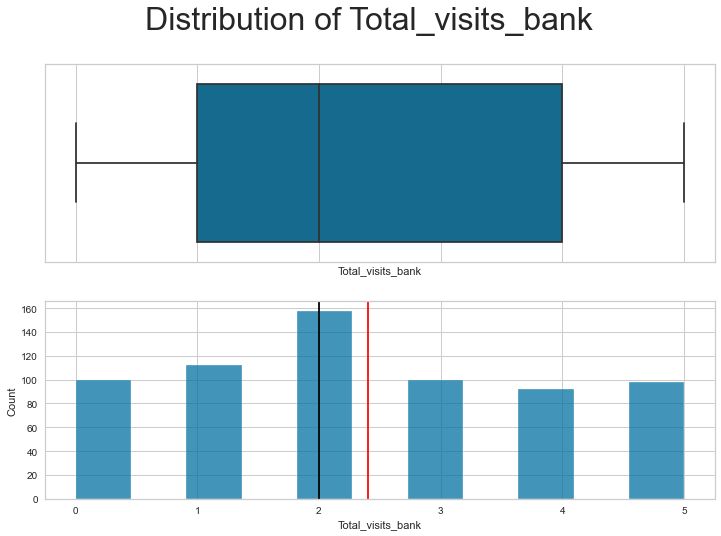

There are 0 lower outliers and 0 upper outliers.
The median of Total_visits_bank is 2.0.
The mean of Total_visits_bank is  2.40
The lower whisker of Total_visits_bank is -3.5
The upper whisker of Total_visits_bank is 8.5
The minimum of Total_visits_bank is 0
The maximum of Total_visits_bank is 5
The standard deviation of Total_visits_bank is  1.63
----------------------------------------------------------


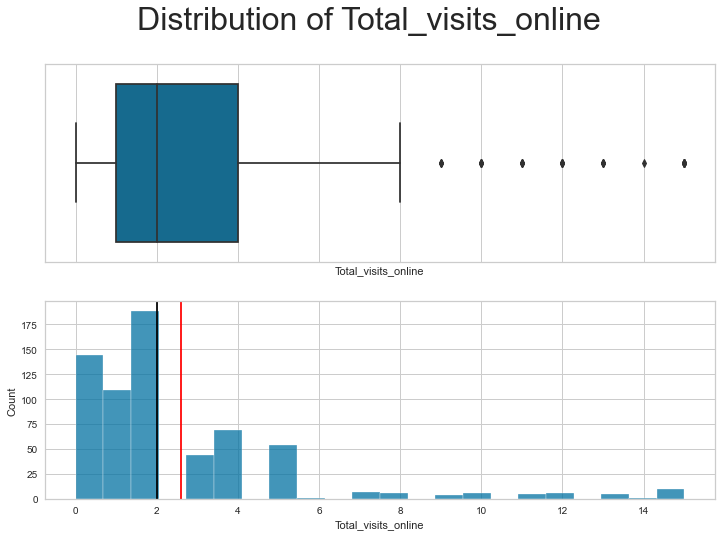

There are 0 lower outliers and 37 upper outliers.
The median of Total_visits_online is 2.0.
The mean of Total_visits_online is  2.61
The lower whisker of Total_visits_online is -3.5
The upper whisker of Total_visits_online is 8.5
The minimum of Total_visits_online is 0
The maximum of Total_visits_online is 15
The standard deviation of Total_visits_online is  2.94
----------------------------------------------------------


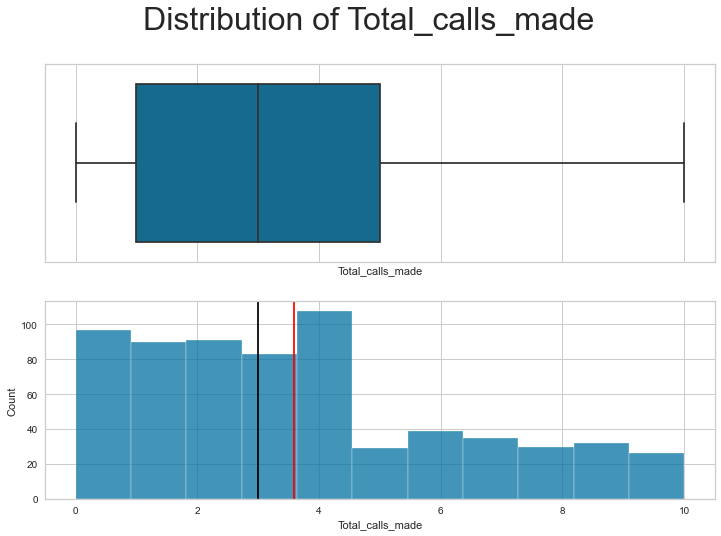

There are 0 lower outliers and 0 upper outliers.
The median of Total_calls_made is 3.0.
The mean of Total_calls_made is  3.58
The lower whisker of Total_calls_made is -5.0
The upper whisker of Total_calls_made is 11.0
The minimum of Total_calls_made is 0
The maximum of Total_calls_made is 10
The standard deviation of Total_calls_made is  2.87
----------------------------------------------------------


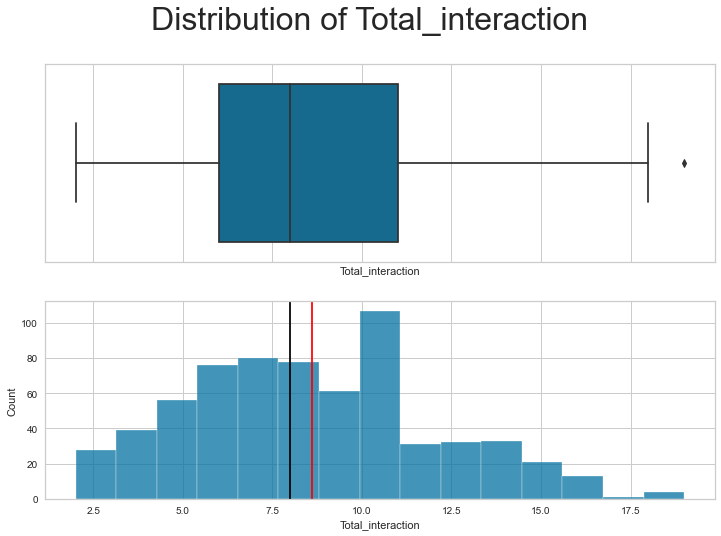

There are 0 lower outliers and 1 upper outliers.
The median of Total_interaction is 8.0.
The mean of Total_interaction is  8.59
The lower whisker of Total_interaction is -1.5
The upper whisker of Total_interaction is 18.5
The minimum of Total_interaction is 2
The maximum of Total_interaction is 19
The standard deviation of Total_interaction is  3.41
----------------------------------------------------------


In [9]:
for feature in var:
    univariate_numeric(cccd, feature) # boxplots and histograms for each feature

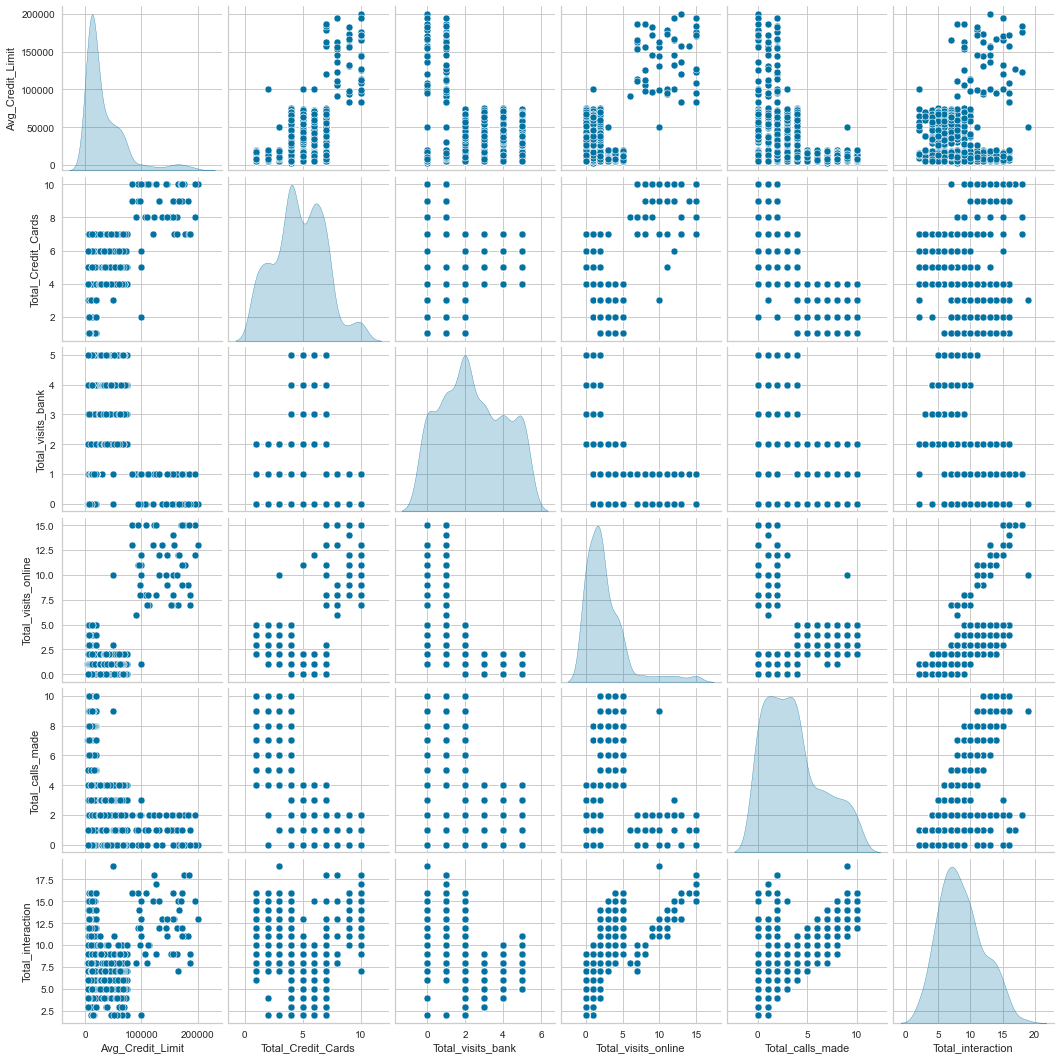

In [10]:
sns.pairplot(sub_cccd, diag_kind='kde'); # shows the pairwise plot for all of the features

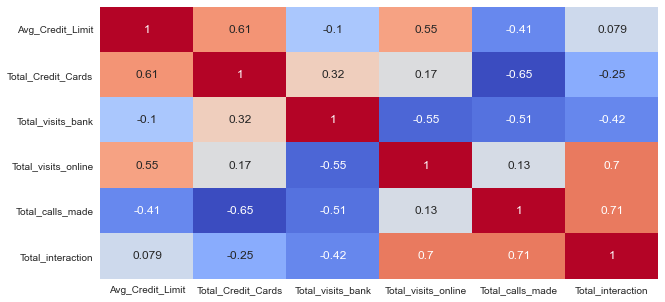

In [11]:
plt.figure(figsize=(10,5)) # figure size chosen for readability
sns.heatmap(sub_cccd.corr(), annot=True, cbar=False, cmap='coolwarm'); # correlation heatmap
plt.show() # shows plot

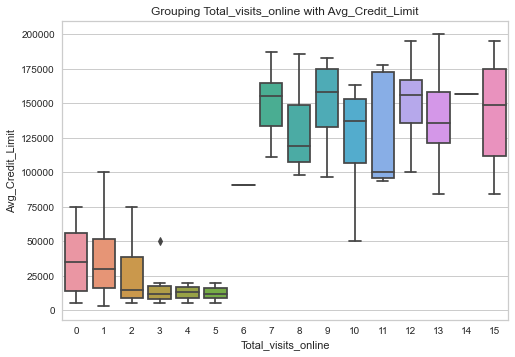

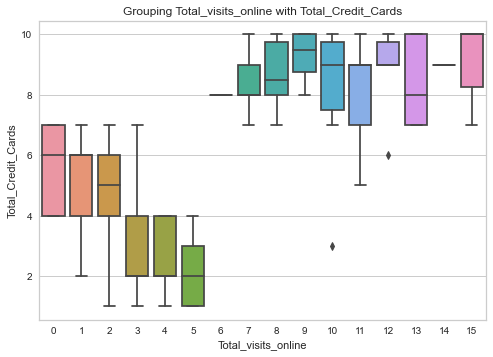

In [12]:
# Is Avg_Credit_Limit or Total_Credit_Cards better to separate Total_visits_online into groups?
sns.boxplot(x=cccd['Total_visits_online'], y=cccd['Avg_Credit_Limit']) # boxplot of Total_visits_online and Avg_Credit_Limit
plt.title('Grouping Total_visits_online with Avg_Credit_Limit') # sets title
plt.show() # shows plot

sns.boxplot(x=cccd['Total_visits_online'], y=cccd['Total_Credit_Cards']) # boxplot of Total_visits_online and Total_Credit_Cards
plt.title('Grouping Total_visits_online with Total_Credit_Cards') # sets title
plt.show() # shows plot

### Quick note:
It appears that Avg_Credit_Limit creates better defined clusters so we will use that while exploring possible 3D clusters.  
The majority of observations are in the lower half of Total_visits_online based on the distribution. We will look for another feature which separates the lower half of Total_visits_online into more clusters.

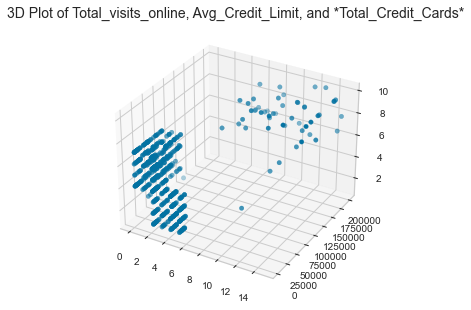

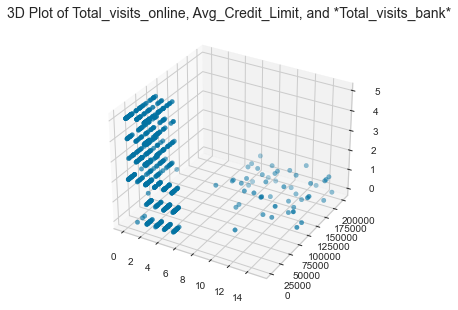

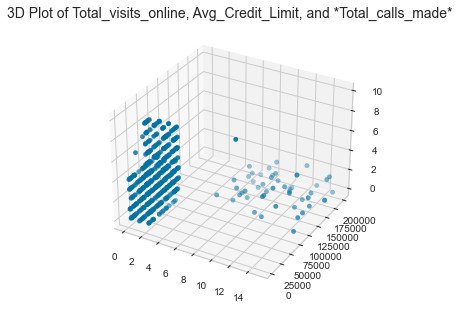

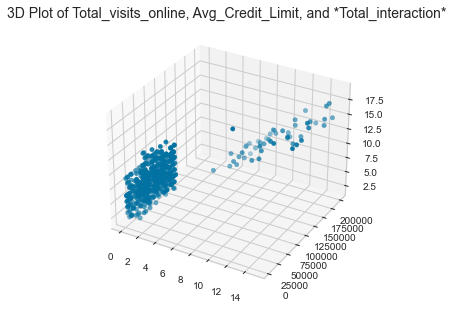

In [13]:
# How do the clusters look when adding an additional feature to Total_visits_online and Avg_Credit_Limit?

other_vars = ['Total_Credit_Cards', 'Total_visits_bank', 'Total_calls_made', 'Total_interaction'] # possible additional features

for variable in other_vars:
    fig = plt.figure(figsize=(8,5)) # makes the plot slightly small
    ax = plt.axes(projection ='3d') # creates the 3D axes
    ax.set_title(f'3D Plot of Total_visits_online, Avg_Credit_Limit, and *{variable}*', fontdict={'fontsize':14}) # sets title
    ax.scatter(cccd['Total_visits_online'], cccd['Avg_Credit_Limit'], cccd[variable]) # 3D scatter plot using additional feature
    plt.show() # shows plot
    print('\n') # adds some space between plots for better readability

### Quick note:
It appears that either Total_Credit_Cards or Total_visits_bank separates the observations further.

## Exploratory Data Analysis Summary:
**Avg_Credit_Limit** has a right-tailed distribution with 39 outliers. It is difficult to say how many clusters based on the kde. The average credit limit is moderately correlated with the other features except for Total_visits_bank.  

**Total_Credit_cards** has a mostly normal distribution with no outliers. There are possibly 4 clusters for this feature. The total credit cards is negatively moderately correlated with Total_calls_made (-.65), but positively moderately correlated with Avg_Credit_Limit (.61) and lightly correlated with Total_visits_bank (.32) and Total_visits_online (.17).  

**Total_visits_bank** has a uniform distribution with no outliers. It is negatively moderately correlated with Total_visits_online (-.55) and Total_calls_made (-.51).  

**Total_visits_online** has a right-tailed distribution with 37 outliers. There might be 2 clusters. It is positively moderately correlated with Avg_Credit_Limit (.55) and negatively moderately correlated with Total_visits_bank (-.55).  

**Total_calls_made** has a slightly right-tailed distribution with no outliers. There might be 2 clusters. It is negative moderately correlated with Avg_Credit_Limit (-.41), Total_Credit_Cards (-.65), and Total_visits_bank (-.51).  

**Total_interaction** is normally distributed. There is 1 outlier. Obviously, it was formed by adding Total_visits_bank, Total_visits_online, and Total_calls_made so it has correlation with those features. However, the correlation with Total_visits_bank is negatively due to the negative relationship between Total_visits_bank and Total_visits_online / Total_calls_made.  

It seems that as someone has more credit cards, they also have a higher limit. Those customers make fewer calls to the bank.  
If someone visited the bank in person, then they were less likely to visit the bank online and less likely to call the bank.   

Based on the distributions, 3 or 4 clusters may be the best estimation. We likely have three clusters using Total_visits_online, Avg_Credit_Limit, and Total_Credit_Cards as seen in the 3D scatter plot.

# Data Preprocessing
As noted previously, there are no missing values to treat.  

We will handle the outliers before scaling the data.

Before the data can be clustered, it must be scaled.

## Handling Outliers
**IMPORTANT NOTE: The models have been run with 3 versions of outlier treatment to see how the outliers impacted the cluster formation. The code without outlier treatment in the first iteration (which is the totality of the code run without the next code section). The second iteration includes the full outlier treatment, treating all of the outliers found. The third and final iteration is the code handling outliers which has not been commented out. The decisions for the final iterations were made based on the results of the first and second iterations of outlier treatment.**

Total_interaction, Total_visits_online, and Avg_Credit_Limit all have outliers.

Total_interaction has 1 upper outlier which can be clipped at 18. This is a fairly simple case.

Total_visits_online has 37 upper outliers which can be clipped at 8.  
**Note: In the models from the first iteration, these outliers formed one of the groups.**  
**In the second iteration, the same groups still formed using the clipped outlier data, but the group was less useful because the defining feature was less descriptive.**

Avg_Credit_Limit has 39 upper outliers which can be clipped at the upper whisker of 105,000.  
**Note: While both models from the first and second iterations could separate out one of the clusters using the outliers from Avg_Credit_Limit or from Total_visits_online, they are usually separated better using the outliers in Total_visits_online. This is partly explained by the positive correlation (.55) between Avg_Credit_Limit and Total_visits_online. We can clip those outliers at 105,000 without damaging the value of the outliers because the relationship is still contained within Total_visits_online as evidenced by the pairwise plot between the two. However, clipping either or both of the features provided no additional value to the clusters.**

In [14]:
sub_cccd['Total_interaction'] = np.clip(a=sub_cccd['Total_interaction'], a_min=0, a_max=18) 
    # handling 1 outlier in Total_interaction
#sub_cccd['Total_visits_online'] = np.clip(a=sub_cccd['Total_visits_online'], a_min=0, a_max=8)
    # handling 37 outliers in Total_visits_online
#sub_cccd['Avg_Credit_Limit'] = np.clip(a=sub_cccd['Avg_Credit_Limit'], a_min=0, a_max=105000)
    # handling 39 outliers in Avg_Credit_Limit

In [15]:
scaler = StandardScaler() # creates scaler object
sub_cccd_scaled = scaler.fit_transform(sub_cccd) # fits and transforms the features to the scaler
sc_df = pd.DataFrame(sub_cccd_scaled, columns = sub_cccd.columns) # creates new dataframe, sc - scaled, df - dataframe
sc_df.head() # quick view of the scaled dataframe

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Total_interaction
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537,-1.938002
1,0.410293,-0.787585,-1.473731,2.520519,1.891859,2.766664
2,0.410293,1.058973,-0.860451,0.134290,0.145528,-0.173752
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528,-0.761835
4,1.740187,0.597334,-1.473731,3.202298,-0.203739,1.884540


# K-Means Clustering

Clusters:1 	Euclidean:  2.2222	Manhattan:  4.7241 	Chebyshev:  1.4894
Clusters:2 	Euclidean:  1.6368	Manhattan:  3.4801 	Chebyshev:  1.0675
Clusters:3 	Euclidean:  1.3030	Manhattan:  2.7257 	Chebyshev:  0.8687
Clusters:4 	Euclidean:  1.1898	Manhattan:  2.4978 	Chebyshev:  0.7939
Clusters:5 	Euclidean:  1.1029	Manhattan:  2.3228 	Chebyshev:  0.7367
Clusters:6 	Euclidean:  1.0512	Manhattan:  2.1970 	Chebyshev:  0.7100
Clusters:7 	Euclidean:  1.0225	Manhattan:  2.1348 	Chebyshev:  0.6942
Clusters:8 	Euclidean:  0.9861	Manhattan:  2.0473 	Chebyshev:  0.6774
Clusters:9 	Euclidean:  0.9551	Manhattan:  1.9902 	Chebyshev:  0.6520
Clusters:10 	Euclidean:  0.9300	Manhattan:  1.9163 	Chebyshev:  0.6444


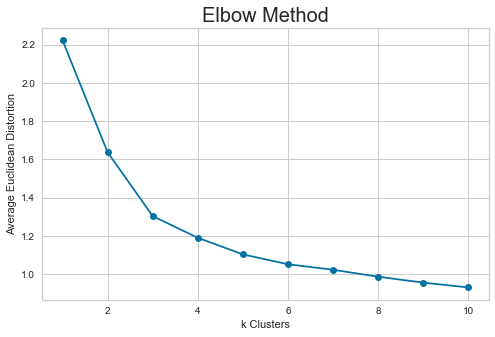

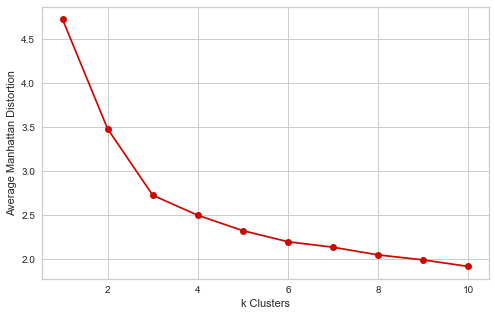

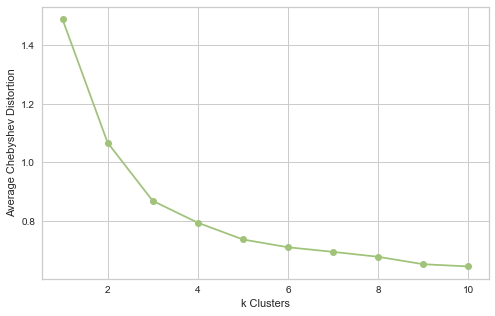

In [16]:
num_of_clusters = np.arange(1,11) # from 1 to 10 clusters
avg_eucl_distortions = [] # empty list for the average euclidean distortions
avg_manh_distortions = [] # empty list for the average manhattan distortions
avg_cheby_distortions = [] # empty list for the average chebyshev distortions

for cluster in num_of_clusters: # iterates for each number of clusters
    kmeans_model = KMeans(n_clusters=cluster) # creates a new model for each numer of clusters
    kmeans_model.fit(sc_df) # fits the model with the scaled data
    pred = kmeans_model.predict(sc_df) # predictions / clustering

    eucl_distortion=(sum(np.min(cdist(sc_df, kmeans_model.cluster_centers_,'euclidean'), axis=1))/sc_df.shape[0])
        # cdist(sub_cccd, model.cluster_centers_, "euclidean") gets the euclidean distance between rows and centroids
        # by choosing the minimum, the closest centroid is chosen for each observation
        # we sum the distances and divide by the rows to get an average distance of an observation to its cluster center
    avg_eucl_distortions.append(eucl_distortion) # adds euclidean distortions to list for plotting
    
    manhattan_distortion=(sum(np.min(cdist(sc_df, kmeans_model.cluster_centers_,'cityblock'), axis=1))/sc_df.shape[0])
        # cityblock calculates the manhattan distance, giving the average distortion based on manhattan distance
    avg_manh_distortions.append(manhattan_distortion) # adds manhattan distortions to list for plotting
    
    chebyshev_distortion = (sum(np.min(cdist(sc_df, kmeans_model.cluster_centers_,'chebyshev'), axis=1))/sc_df.shape[0])
        # this gives the average distortion based on chebyshev distance
    avg_cheby_distortions.append(chebyshev_distortion) # adds chebyshev distortions to list for plotting 
    
    print(f'Clusters:{cluster} \tEuclidean: {eucl_distortion : 0.4f}' \
          f'\tManhattan: {manhattan_distortion : 0.4f} \tChebyshev: {chebyshev_distortion : 0.4f}')
         # creates a printed block giving the clusters and the distortions
        
plt.figure(figsize=(8,5)) # sets figure size
plt.plot(num_of_clusters, avg_eucl_distortions, 'bo-') # euclidean distortions, plotted in blue
plt.xlabel('k Clusters') # labels the x-axis
plt.ylabel('Average Euclidean Distortion') # labels the y-axis
plt.title('Elbow Method', fontdict={'fontsize':20}) # puts a large title above the first plot, effectively serving all 3 plots
plt.show() # shows the plot

plt.figure(figsize=(8,5)) # sets figure size
plt.plot(num_of_clusters, avg_manh_distortions, 'ro-') # manhattan distortions, plotted in red
plt.xlabel('k Clusters') # labels the x-axis
plt.ylabel('Average Manhattan Distortion') # labels the y-axis
plt.show() # shows the plot

plt.figure(figsize=(8,5)) # sets figure size
plt.plot(num_of_clusters, avg_cheby_distortions, 'go-') # chebyshev distortions, plotted in green
plt.xlabel('k Clusters') # labels the x-axis
plt.ylabel('Average Chebyshev Distortion') # labels the y-axis
plt.show() # shows the plot

### Elbow Method Notes:
All of the elbow method plots show the same trend. The ideal number of clusters is 3, 4 or 5.

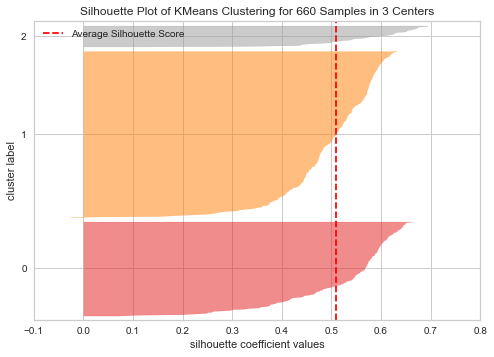

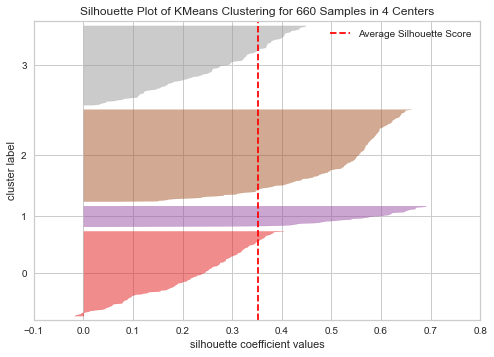

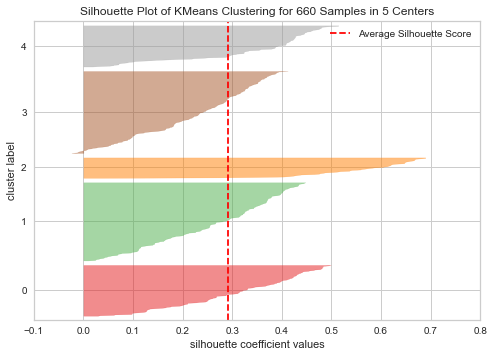

In [17]:
for k in [3, 4, 5]: # viewing the silhouettes for k = 3, 4, and 5
    visualizer = SilhouetteVisualizer(KMeans(k, random_state=7)) # initializes SilhouetteVisualizer object
    visualizer.fit(sc_df) # fits the visualizer to the scaled dataframe
    visualizer.show() # shows the plots

## Selection of K for KMeans Clustering
We could choose 3, 4, or 5 based on the Elbow Method.  
Of those choices, 3 clusters has the highest average silhouette score.

In [18]:
kmeans_model = KMeans(n_clusters=3, random_state=7) # creating kmeans model for k=3
kmeans_model.fit(sc_df) # fitting the model to the scaled data
cccd['Kmeans Groups'] = kmeans_model.labels_ # adding the group labels to the original data to pair customer ID with group
sub_cccd['Groups'] = kmeans_model.labels_ # adding the group labels to the subgroup of the analyzed features
segmentation = sub_cccd.groupby('Groups').mean() # summary dataframe of the analyzed features by group, looking at mean values

group_counts = [] # empty list to hold group sizes
for n in np.arange(0, kmeans_model.cluster_centers_.shape[0]): # cluster_centers_.shape[0] gives the number of clusters
    count = (kmeans_model.labels_ == n).sum() # evaluates whether a label is in the group, then sums the number of 'True' cases
    group_counts.append(count) # adds the label count to the list
segmentation['Group Size'] = group_counts # takes the list of group counts and adds it to the summary dataframe 
print('Mean of Features for each Cluster:') # clarification of table values
segmentation # shows the summary dataframe, mean values of the features and group sizes

Mean of Features for each Cluster:


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Total_interaction,Group Size
Groups,,,,,,,
0,12217.19457,2.402715,0.936652,3.579186,6.932127,11.443439,221
1,33591.25964,5.496144,3.467866,0.987147,2.002571,6.457584,389
2,141040.00000,8.740000,0.600000,10.900000,1.080000,12.580000,50


In [19]:
print('Standard Deviation of Features for each Cluster:') # clarification of table values
sub_cccd.groupby('Groups').std() # summary dataframe of the analyzed features by group, looking at standard deviation

Standard Deviation of Features for each Cluster:


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Total_interaction
Groups,,,,,,
0,5247.326012,1.101978,0.800889,1.205790,1.925879,2.401271
1,22193.270683,1.159057,1.160839,0.856954,1.429618,2.004216
2,34457.877272,1.274715,0.494872,2.880264,0.876915,3.004011


### Visualising the Cluster Differences

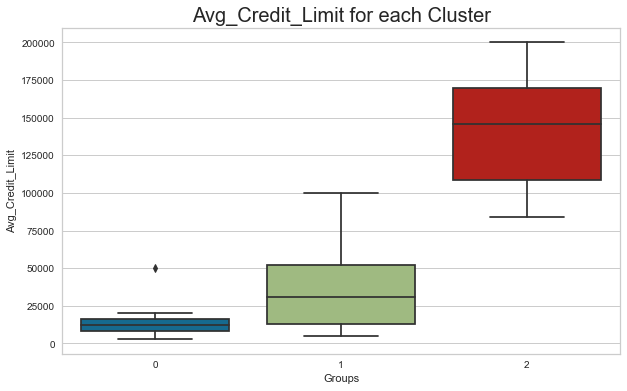

___________________________________________________________________________________


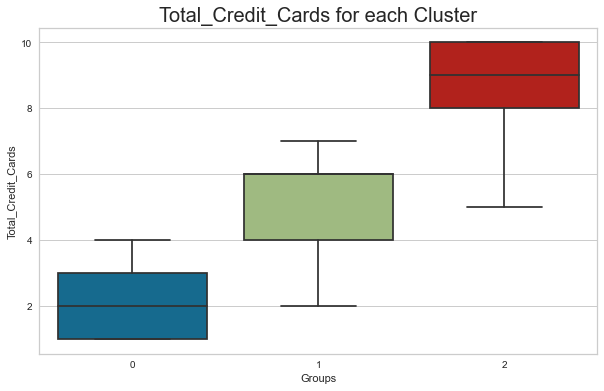

___________________________________________________________________________________


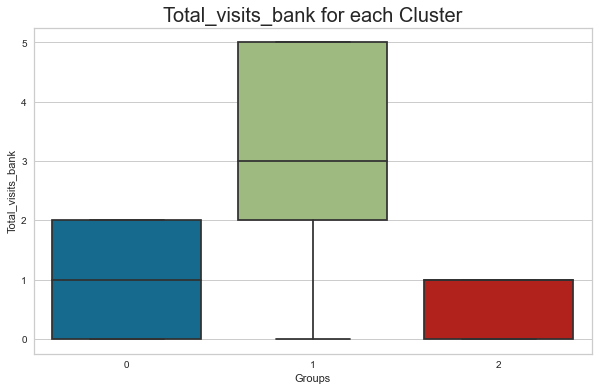

___________________________________________________________________________________


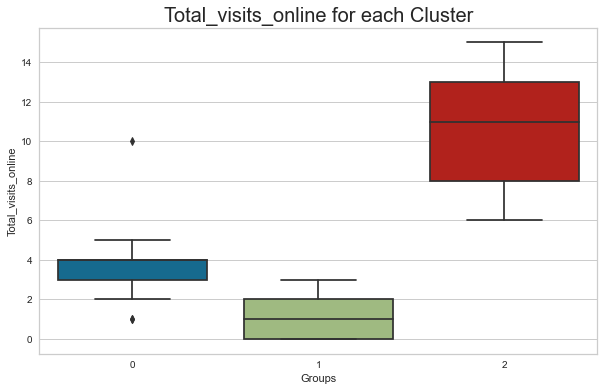

___________________________________________________________________________________


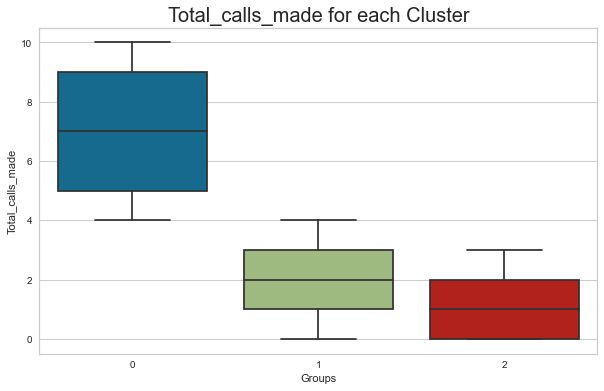

___________________________________________________________________________________


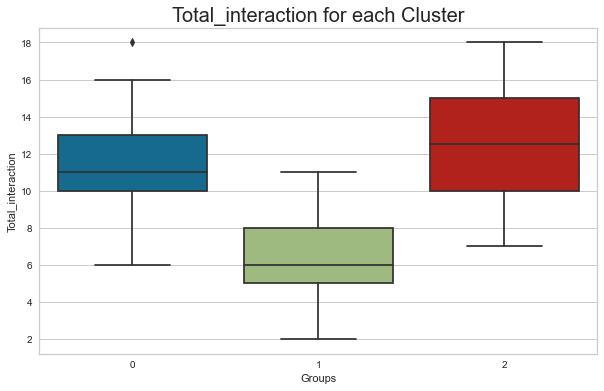

___________________________________________________________________________________


In [20]:
# Boxplots with respect to groups
for feature in var: # feature list
    plt.figure(figsize=(10,6)) # sizes the plot
    sns.boxplot(x=sub_cccd['Groups'], y=sub_cccd[feature]) # groups on the x-axis, features on the y-axis
    plt.title(f'{feature} for each Cluster', fontdict={'fontsize':20}) # title for the plots with a font size of 20
    plt.show() # shows the plot
    print('___________________________________________________________________________________') # additional separation

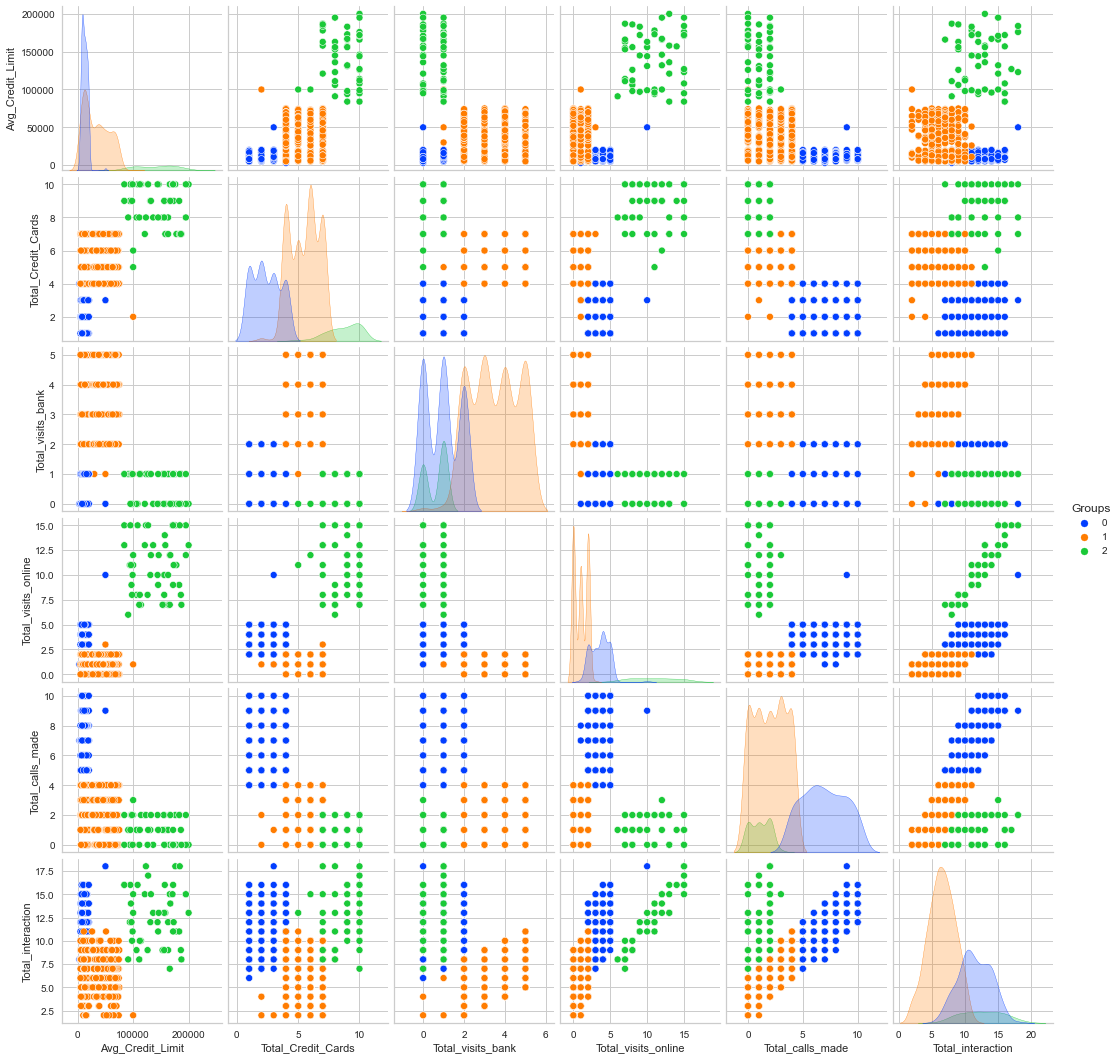

In [21]:
sns.pairplot(sub_cccd, hue='Groups', palette='bright') # pairwise plots shown again, now with respect to groups

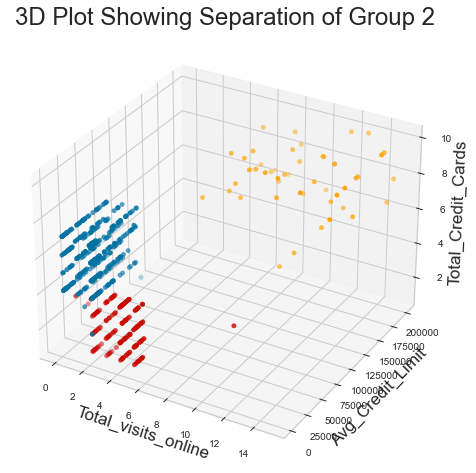

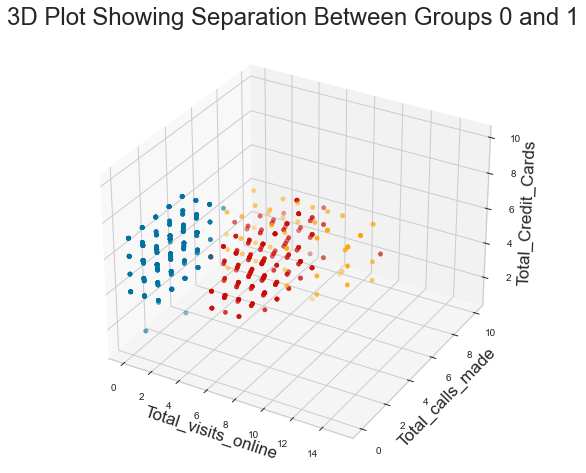

In [22]:
kgroup0 = sub_cccd.groupby('Groups').get_group(0) # observations in group 0
kgroup1 = sub_cccd.groupby('Groups').get_group(1) # observations in group 1
kgroup2 = sub_cccd.groupby('Groups').get_group(2) # observations in group 2

# Best 3D scatter plot prediction from EDA shown by clusters
fig = plt.figure(figsize=(12,8)) # makes the plot larger
ax = plt.axes(projection ='3d') # creates the 3D axes
ax.set_title(f'3D Plot Showing Separation of Group 2', fontdict={'fontsize':24}) #sets title
ax.scatter(kgroup0['Total_visits_online'], kgroup0['Avg_Credit_Limit'], kgroup0['Total_Credit_Cards'], c='r') # group 0 in red
ax.scatter(kgroup1['Total_visits_online'], kgroup1['Avg_Credit_Limit'], kgroup1['Total_Credit_Cards'], c='b') # group 1 in blue
ax.scatter(kgroup2['Total_visits_online'], kgroup2['Avg_Credit_Limit'], kgroup2['Total_Credit_Cards'],c='orange')#orange group 2
ax.set_xlabel('Total_visits_online', fontsize = 17) # x-axis label, font size is 17
ax.set_ylabel('Avg_Credit_Limit', fontsize = 17) # y-axis label, font size is 17
ax.set_zlabel('Total_Credit_Cards', fontsize = 17) # z-axis label, font size is 17
plt.show() # shows plot

# Best 3D scatter plot based on Cluster Summary Statistics
fig = plt.figure(figsize=(12,8)) # makes the plot larger
ax = plt.axes(projection ='3d') # creates the 3D axes
ax.set_title(f'3D Plot Showing Separation Between Groups 0 and 1', fontdict={'fontsize':24}) #sets title
ax.scatter(kgroup0['Total_visits_online'], kgroup0['Total_calls_made'], kgroup0['Total_Credit_Cards'], c='r') # group 0 in red
ax.scatter(kgroup1['Total_visits_online'], kgroup1['Total_calls_made'], kgroup1['Total_Credit_Cards'], c='b') # group 1 in blue
ax.scatter(kgroup2['Total_visits_online'], kgroup2['Total_calls_made'], kgroup2['Total_Credit_Cards'],c='orange')#orange group 2
ax.set_xlabel('Total_visits_online', fontsize = 17) # x-axis label, font size is 17
ax.set_ylabel('Total_calls_made', fontsize = 17) # y-axis label, font size is 17
ax.set_zlabel('Total_Credit_Cards', fontsize = 17) # z-axis label, font size is 17
plt.show() # shows plot

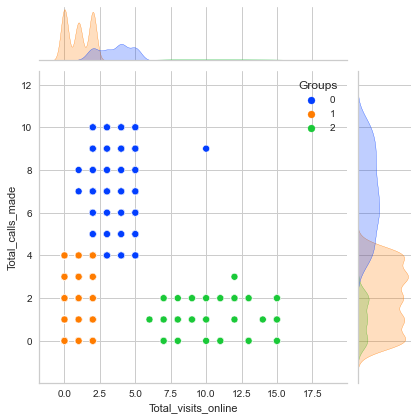

In [23]:
sns.jointplot(x=sub_cccd['Total_visits_online'], y=sub_cccd['Total_calls_made'], hue=sub_cccd['Groups'], palette='bright')
    # best pairwise plot to show all 3 groups

### Visualising Cluster Differences Notes:
From the boxplots, we can see that Total_visits_online provided the most separation between groups. There is overlap between Group 0 and the top 25% of Group 1 (2 to 3 online visits) and with some outliers in Group 0. However, that is the only overlap. The groups can be cleanly separated for the other numbers of online visits.  

Furthermore, in the EDA we found groups which the model shows as well. When looking at the best 3D scatter plot found in the EDA, the groups are clearly formed by Total_visits_online, Avg_Credit_Limit, and Total_Credit_Cards. This is the 3D plot showing separation of Group 2.  

The 3D plot using Total_calls_made instead of Avg_Credit_Limit separates Group 0 and Group 1 better than the other 3D plot.

Looking at the cluster summary statistics, we see the general distributions ($\mu \pm \sigma$):  

| Groups  | Avg_Credit_Limit | Total_visits_online | Total_Credit_Cards | Total_calls_made |
|---------|------------------|---------------------|--------------------|------------------|
| Group 0 | 12217 $\pm$ 5247 | 3.58 $\pm$ 1.21    | 2.40 $\pm$ 1.10   | 6.93 $\pm$ 1.93 |
| Group 1 | 33591 $\pm$ 22193 | .99 $\pm$ .86    | 5.50 $\pm$ 1.16   | 2.00 $\pm$ 1.43 |
| Group 2 | 141040 $\pm$ 34458 | 10.90 $\pm$ 2.88    | 8.74 $\pm$ 1.27   | 1.08 $\pm$ .88 |

Group 2 (cluster size of 50) is well separated from the other groups by Total_visits_online.  

Group 0 and Group 1 can be fairly well separated by Total_calls_made.  
Even though Total_calls_made does not separate Group 1 and Group 2 well, Group 2 can be isolated first using Total_visits_online.  

All three groups can be clearly seen in the pairwise plot of Total_visits_online and Total_calls_made.

#### Cluster Profile Summary:
Those from Group 2 visit the bank online more freqently than other groups.  
Group 0 makes more calls to the bank than the other groups.  
Group 1 are customers who call the bank than and visit online less. They have less interaction with the bank overall than the other groups.  

# Hierarchical Clustering

In [24]:
links = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward'] 
    # all possible linkage methods, though from the notes in the scipy.cluster.hierarchy.linkage documentation:
    # Methods ‘centroid’, ‘median’, and ‘ward’ are correctly defined only if Euclidean pairwise metric is used
distances = ['chebyshev', 'cityblock', 'euclidean'] # several distance metrics

for method in links: # tests different linkages
    if (method == 'centroid' or method == 'median' or method == 'ward'): # these linkage methods only work with Euclidean
        coph_corr, coph_dist=cophenet(linkage(sc_df, metric='euclidean', method=method), pdist(sc_df))
            # for these methods, we only use euclidean distances
        print(f'Cophenetic Correlation: {coph_corr : 0.4f}\t\tDistance Metric: {metric}\tLinkage: {method}') 
            # shows cophenetic correlation under different conditions 
    else: # for the other linkage methods that can use other distance metrics
        for metric in distances: # iterates through the distance metrics
            coph_corr, coph_dist=cophenet(linkage(sc_df, metric=metric, method=method), pdist(sc_df)) 
                # gets cophenetic correlations using the scaled dataframe and the pairwise distances
            print(f'Cophenetic Correlation: {coph_corr : 0.4f}\t\tDistance Metric: {metric}\tLinkage: {method}')
                # shows cophenetic correlation under different conditions

Cophenetic Correlation:  0.6987		Distance Metric: chebyshev	Linkage: single
Cophenetic Correlation:  0.6870		Distance Metric: cityblock	Linkage: single
Cophenetic Correlation:  0.6995		Distance Metric: euclidean	Linkage: single
Cophenetic Correlation:  0.7601		Distance Metric: chebyshev	Linkage: complete
Cophenetic Correlation:  0.8256		Distance Metric: cityblock	Linkage: complete
Cophenetic Correlation:  0.8393		Distance Metric: euclidean	Linkage: complete
Cophenetic Correlation:  0.8780		Distance Metric: chebyshev	Linkage: average
Cophenetic Correlation:  0.8791		Distance Metric: cityblock	Linkage: average
Cophenetic Correlation:  0.8789		Distance Metric: euclidean	Linkage: average
Cophenetic Correlation:  0.8780		Distance Metric: chebyshev	Linkage: weighted
Cophenetic Correlation:  0.8173		Distance Metric: cityblock	Linkage: weighted
Cophenetic Correlation:  0.8123		Distance Metric: euclidean	Linkage: weighted
Cophenetic Correlation:  0.8749		Distance Metric: euclidean	Linkage: cent

### Notes:
We must produce dendrograms for each linkage method so we will choose the most appropriate distance metrics based on the cophenetic correlation for each linkage method.  

**Single linkage** was best with euclidean distance, though chebyshev distance was a very close second.  
**Complete linkage** was best with euclidean distance.  
**Average linkage** was best with cityblock distance, though other distance metrics were similar.  
**Weighted linkage** was best with chebyshev distance.  
**Centroid, median, and ward linkages** can only be used with euclidean distance.  

Also, note that average linkage had higher overall cophenetic correlation.

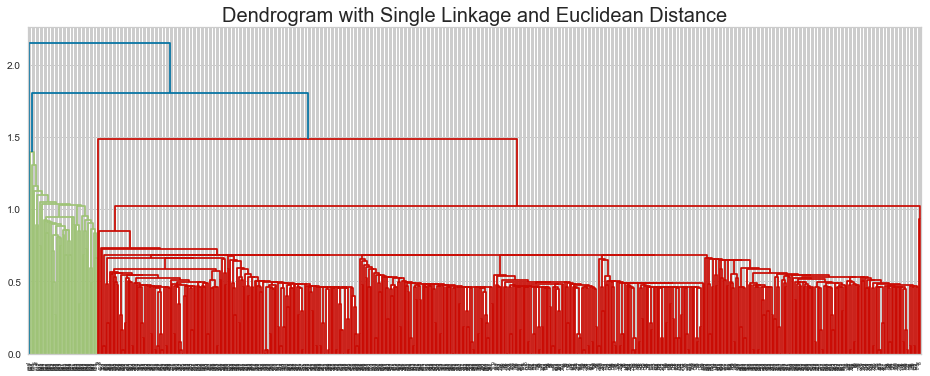

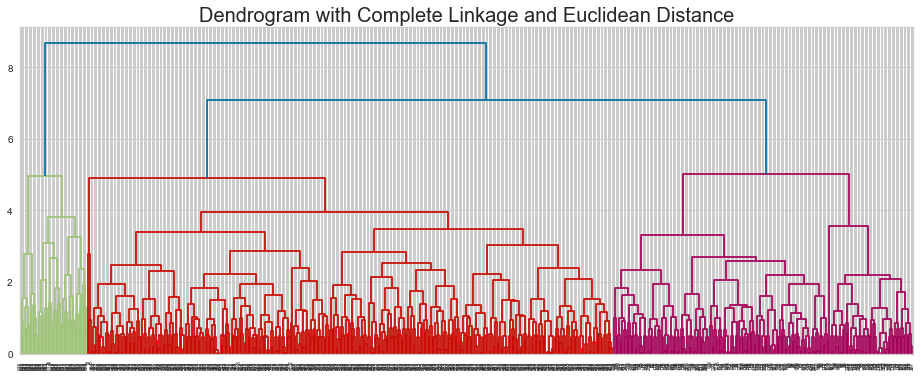

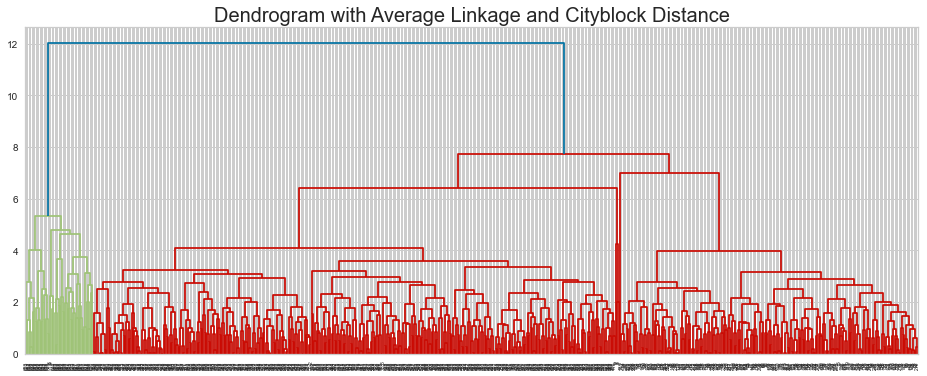

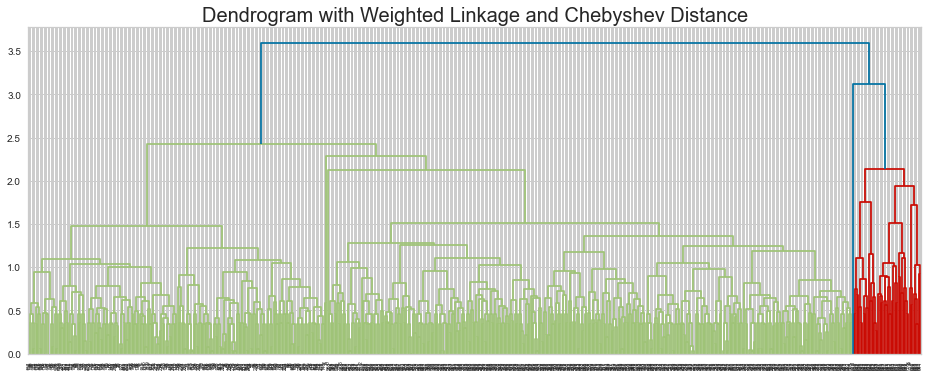

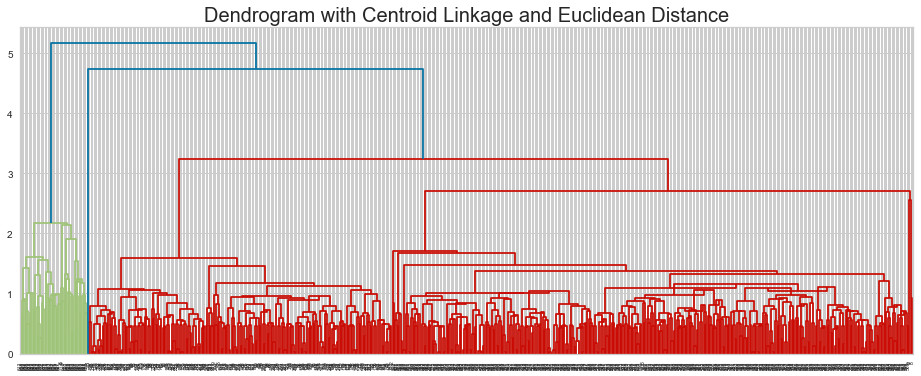

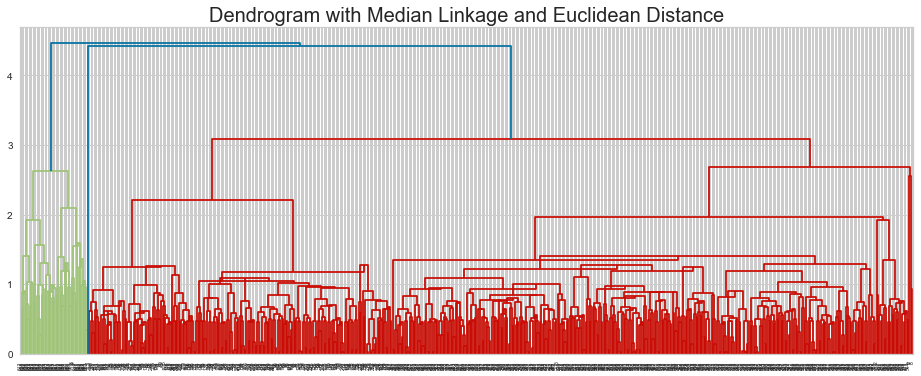

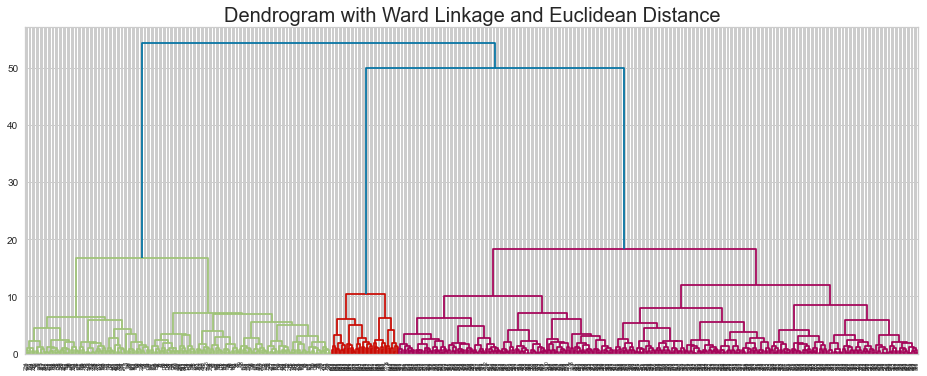

In [25]:
metric_method_pairs = [('single', 'euclidean'), ('complete', 'euclidean'), ('average', 'cityblock'), 
                       ('weighted', 'chebyshev'), ('centroid', 'euclidean'), ('median', 'euclidean'), ('ward', 'euclidean')]
        # these are the linkage methods paired with the distance metrics which provided the highest cophenetic correlation

for method, metric in metric_method_pairs: # method is linkage, metric is distance
    plt.figure(figsize=(16,6)) # longer plot
    plt.title(f'Dendrogram with {method.capitalize()} Linkage and {metric.capitalize()} Distance', fontdict={'fontsize':20})
        # creates title for each plot which includes the types of linkage and distance
    dendrogram(linkage(sc_df, metric=metric, method=method)) # creates a dendrogram for each linkage
    plt.show() # shows the dendrogram plot

### Dendrogram Notes:
As the dendrogram height has different values, we will consider the approximate ratio of the cutoff height to the total height.  
Our choice will also be determined by cluster size and number. We prefer clusters of similar sizes if all else is equal and we prefer fewer clusters if all else is equal.  

**Single Linkage Dendrogram**
- The number of clusters rapidly increase at around 1.10 of 2.4 dendrogram height. However, the clusters formed at that height are very small clusters. The majority of the observation fall into one large cluster. To partition most of the observations well, we need an absurd number of clusters.  
- We will not use single linkage.

**Complete Linkage Dendrogram**
- A cutoff at around 5 of 8.5 with 3 clusters provides similar group sizes to the K-means model. A cutoff at around 4.2 of 8.5 creates 6 clusters. Beyond that, the number of clusters increases rapidly for little gain in similarity.  
- 6 clusters reduces the dendrogram height by half.  

**Average Linkage Dendrogram**
- This could work with 3 clusters, though the split to make 4 clusters does not appear to be very useful as it is so small. After that, we start partitioning the smaller group before touching the larger groups as we increase the number of clusters.

**Weighted Linkage Dendrogram**
- At 3 clusters, one of the clusters is tiny and not very useful.  4 clusters at around 2.4 of 3.6 dendrogram height provides similar results as the 3 clusters provided by other linkage methods.

**Centroid Linkage Dendrogram**
- This has similar problems to the Weighted Linkage Dendrogram, but it has a reduced height ratio compared to the Weighted Linkage Dendrogram.  

**Median Linkage Dendrogram**
- This can form 3 good clusters like many of the other dendrograms, but it creates very small clusters before partitioning the larger clusters so it is less useful than the Complete Linkage.

**Ward Linkage Dendrogram**
- This has much better splits with evenly sized groups and large dendrogram height reduction.  
- Both 3 clusters and 5 clusters would be reasonable. There is enough reduction in height from 3 to 5 to justify 5 clusters.   

We will explore the cluster profile of 5 clusters using the Ward Linkage.

In [26]:
hierarchy_model = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward') # creates agglomerative model
hierarchy_model.fit(sc_df) # fits the model to the scaled data

cccd['Hierarchy Groups'] = hierarchy_model.labels_ # adding the group labels to the original data to pair customer ID with group
sub_cccd['Groups'] = hierarchy_model.labels_ # adding the group labels to the subgroup of the analyzed features
print('Mean Values of Feature grouped by Clusters')
display(sub_cccd.groupby('Groups').mean()) # summary dataframe of the analyzed features by group, looking at mean values
print('\n\nStandard Deviation of Feature grouped by Clusters')
display(sub_cccd.groupby('Groups').std()) # summary dataframe of the analyzed features by group, looking at standard deviation

Mean Values of Feature grouped by Clusters


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Total_interaction
Groups,,,,,,
0,32768.888889,5.613333,4.275556,1.071111,1.977778,7.324444
1,35446.540881,5.358491,2.364780,0.842767,1.974843,5.182390
2,141040.000000,8.740000,0.600000,10.900000,1.080000,12.580000
3,12305.970149,2.611940,0.858209,3.246269,5.656716,9.761194
4,12054.347826,2.217391,1.119565,3.967391,8.630435,13.706522




Standard Deviation of Feature grouped by Clusters


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Total_interaction
Groups,,,,,,
0,21948.598863,1.116756,0.722457,0.863088,1.428175,1.764374
1,22452.945960,1.208006,0.589157,0.830850,1.413988,1.622061
2,34457.877272,1.274715,0.494872,2.880264,0.876915,3.004011
3,4870.083002,1.156287,0.796165,1.140087,1.298377,1.580802
4,6046.275996,1.077503,0.836560,1.217556,1.290007,1.288478


In [27]:
for n in np.arange(0, hierarchy_model.n_clusters_): # creates a list of labels
    count = (hierarchy_model.labels_ == n).sum() # counts the number of label in each group
    print(f'Group: {n} \t Group Size: {count}') # prints a summary of the group sizes

Group: 0 	 Group Size: 225
Group: 1 	 Group Size: 159
Group: 2 	 Group Size: 50
Group: 3 	 Group Size: 134
Group: 4 	 Group Size: 92


### Visualising the Cluster Differences

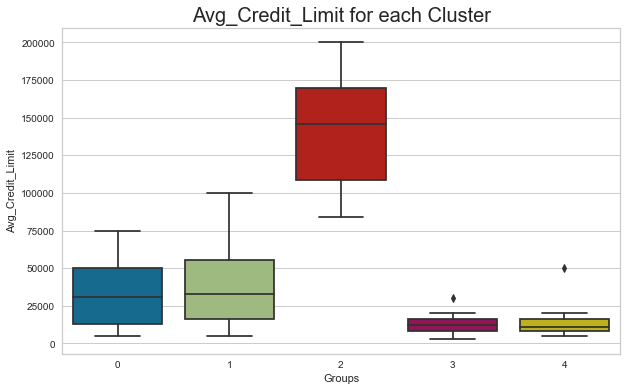

___________________________________________________________________________________


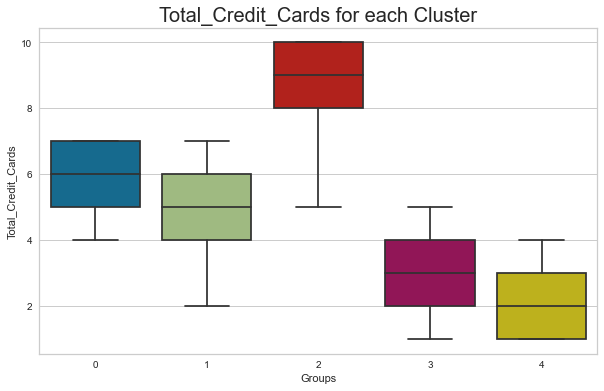

___________________________________________________________________________________


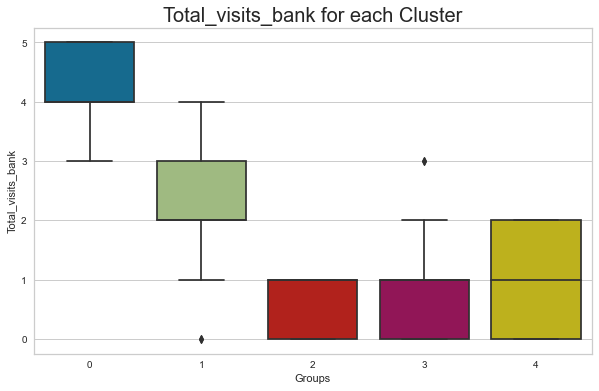

___________________________________________________________________________________


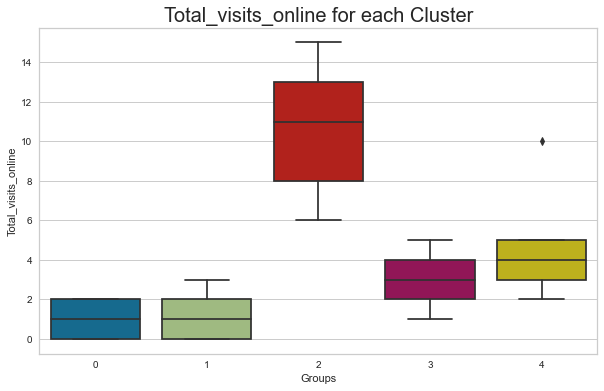

___________________________________________________________________________________


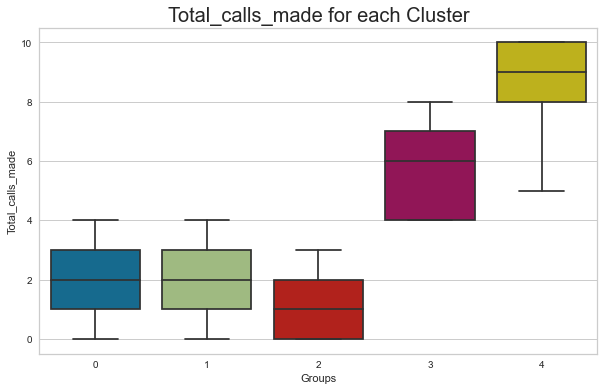

___________________________________________________________________________________


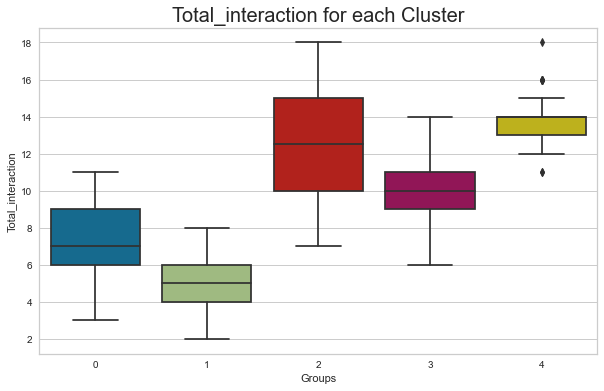

___________________________________________________________________________________


In [28]:
# Boxplots with respect to groups
for feature in var: # feature list
    plt.figure(figsize=(10,6)) # sizes the plot
    sns.boxplot(x=sub_cccd['Groups'], y=sub_cccd[feature]) # groups on the x-axis, features on the y-axis
    plt.title(f'{feature} for each Cluster', fontdict={'fontsize':20}) # title for the plots with a font size of 20
    plt.show() # shows the plot
    print('___________________________________________________________________________________') # additional separation

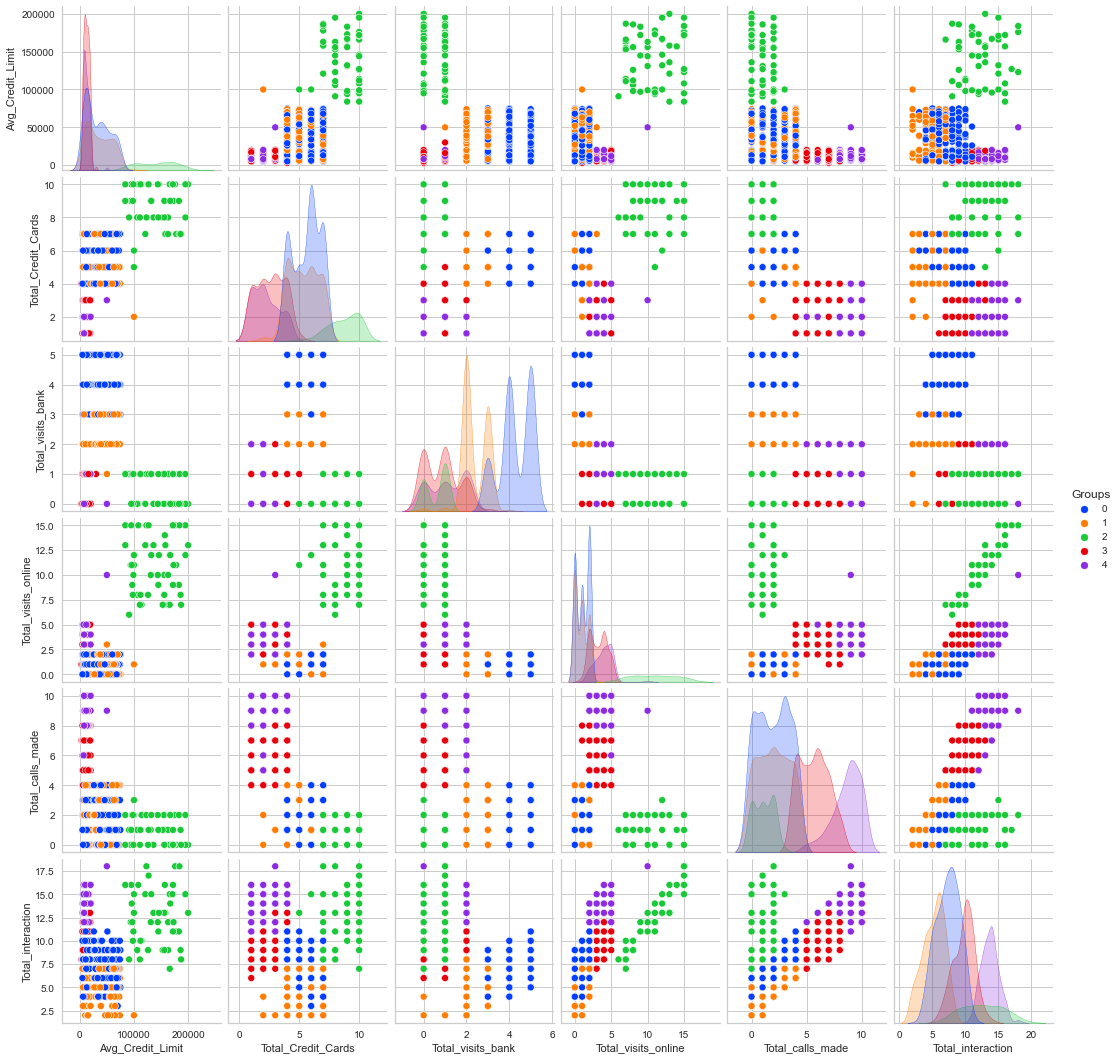

In [29]:
sns.pairplot(sub_cccd, hue='Groups', palette='bright') # pairwise plots shown again, now with respect to groups

### Notes:
Group 0 does not separate from the other groups cleanly, but there is some non-overlapped space in the KDE for Total_interaction and Total_visits_bank. There is limited overlap in Total_visits_bank with Groups 1, 3, and 4. Total_calls_made separates Group 0 from Groups 3 and 4 well. Group 0 and Group 1 are quite similar with the main separation occurring through Total_visits_bank. The Total_visits_bank / Total_calls_made pairwise plot  is best to see the isolated Group 0 space.    

Group 1 shares much of the same space as Group 0 and it separated from Groups 2, 3, and 4 in the same ways. Group 1 tends to have slightly fewer Total_visits_bank than Group 0.

Group 2 is the most easily separated. It separates well using Total_visits_online as it does not share any of the same values except for an outlier in Group 4.  

Group 3 tends to share some space with Group 4. Total_calls_made is the best separator for Group 3. It has some overlap with Groups 1, 2, and 4. However, many of the observations are within its own unique space.  

Group 4 can also be separated by Total_call_made as the majority of the observations have their own unique space. Group 4 tends to have a higher number of call made than Group 3. 

We could reduce to 3 clusters by grouping 3 and 4 and grouping 0 and 1 as those groups share many of the features in common.  

Our main separation features are Total_visits_bank, Total_calls_made and Total_visits_online.

#### Cluster Profile Summary:
Group 0 visits the bank in person often, but they don't call the bank or visit online often.  

Group 1 is similar to Group 0, but they have less total interaction because they visit the bank in person less frequently than Group 0.  

Group 2 calls the bank the least and visits the bank in person the least compared to other groups. However, they visit the bank online by far the most. They have the highest overall interaction with the bank.  

Group 3 rarely goes to the bank in person and sometimes visits online. They mostly call the bank.  

Group 4 is similar to Group 3, but they call the bank more often than Group 3.

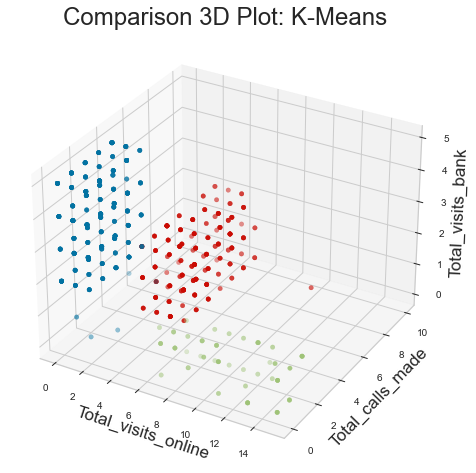

______________________________________________________________


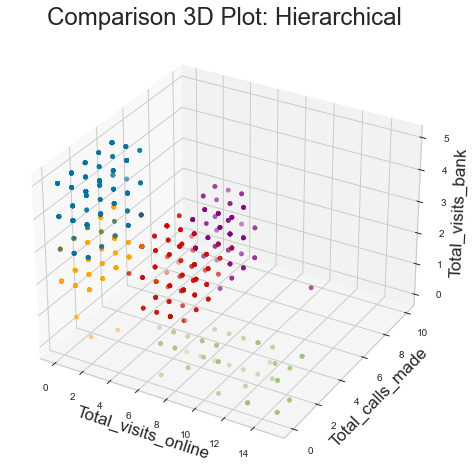

In [30]:
# Defining the groups
group0 = sub_cccd.groupby('Groups').get_group(0) # observations in group 0
group1 = sub_cccd.groupby('Groups').get_group(1) # observations in group 1
group2 = sub_cccd.groupby('Groups').get_group(2) # observations in group 2
group3 = sub_cccd.groupby('Groups').get_group(3) # observations in group 3
group4 = sub_cccd.groupby('Groups').get_group(4) # observations in group 4

# Comparison 3D Plot of K-Means Model
fig = plt.figure(figsize=(12,8)) # makes the plot larger
ax = plt.axes(projection ='3d') # creates the 3D axes
ax.set_title(f'Comparison 3D Plot: K-Means', fontdict={'fontsize':24}) #sets title
ax.scatter(kgroup0['Total_visits_online'], kgroup0['Total_calls_made'], kgroup0['Total_visits_bank'], c='r') # group 0 in red
ax.scatter(kgroup1['Total_visits_online'], kgroup1['Total_calls_made'], kgroup1['Total_visits_bank'], c='b') # group 1 in blue
ax.scatter(kgroup2['Total_visits_online'], kgroup2['Total_calls_made'], kgroup2['Total_visits_bank'], c='g') # green group 2
ax.set_xlabel('Total_visits_online', fontsize = 17) # x-axis label, font size is 17
ax.set_ylabel('Total_calls_made', fontsize = 17) # y-axis label, font size is 17
ax.set_zlabel('Total_visits_bank', fontsize = 17) # z-axis label, font size is 17
plt.show() # shows plot

print('______________________________________________________________') # provides some separation between the plots

# Best 3D scatter plot based on other visual information of Hierarchical Model
fig = plt.figure(figsize=(12,8)) # makes the plot larger
ax = plt.axes(projection ='3d') # creates the 3D axes
ax.set_title(f'Comparison 3D Plot: Hierarchical', fontdict={'fontsize':24}) #sets title
ax.scatter(group0['Total_visits_online'], group0['Total_calls_made'], group0['Total_visits_bank'], c='b') # blue group 0
ax.scatter(group1['Total_visits_online'], group1['Total_calls_made'], group1['Total_visits_bank'], c='orange') # orange group 1
ax.scatter(group2['Total_visits_online'], group2['Total_calls_made'], group2['Total_visits_bank'], c='g') # green group 2
ax.scatter(group3['Total_visits_online'], group3['Total_calls_made'], group3['Total_visits_bank'], c='r') # red group 3
ax.scatter(group4['Total_visits_online'], group4['Total_calls_made'], group4['Total_visits_bank'], c='purple') # purple group 4
ax.set_xlabel('Total_visits_online', fontsize = 17) # x-axis label, font size is 17
ax.set_ylabel('Total_calls_made', fontsize = 17) # y-axis label, font size is 17
ax.set_zlabel('Total_visits_bank', fontsize = 17) # z-axis label, font size is 17
plt.show() # shows plot

# Comparing the K-Means Model and the Hierarchical Model

In the <u>K-Means model</u>, we used 3 clusters. Those 3 clusters could be effectively separated only using Total_visits_online and Total_calls_made. The cluster sizes were 221, 389, and 50.  

In the <u>Hierarchical model</u>, we used 5 clusters. Those clusters could be effectively separated only using Total_visits_bank, Total_visits_online, and Total_calls_made. The cluster sizes were 225, 159, 50, 134, and 92.   


#### Comparing Group Spaces on Pairwise Plots 
Group 2 for both the K-Means model and the Hierarchical model have the same group size and they occupy the same spaces in the pairwise plots. Group 2 is the same cluster is both models. This makes sense as it handles the outliers. These are the customers with a high number of total visits online. 

K-Means Group 0 (group size 221) corresponds to the Hierarchical Groups 3 and 4 (group sizes 134 and 92, 226 total). These groups were composed of customers with a high number of calls to the bank. Of the high number of calls, Hierarchical Group 4 had a higher number of calls than Hierarchical Group 3.  

K-Means Group 1 (group size 389) corresponds to the Hierarchical Groups 0 and 1 (group sizes 225 and 159, 384 total). These groups were composed of customers with a high number of visits to the bank. Of the high number of visits in person to the bank, Hierarchical Group 0 had a higher number of visits than Hierarchical Group 1.  

While the groups follow the same trends, 5 observations from the K-Means Group 1 did not go to Hierarchical Group 0 or 1. It appears from the pairwise plot of Total_visits_bank and Total_visits_online that those observations went to Hierarchical Group 3. In the K-Means pairwise plot of Total_visits_bank and Total_visits_online, this occurred on the boundary of Group 0 and Group 1.  

# Conclusion: Key Takeaways and Recommendations
Whether you use the K-Means model or the Hierarchical model, the group pattern is the same. The customers are segmented based on their type of interaction with the bank. 
- There is a strong separation between customers who prefer to visit the bank online and those who prefer to visit the bank in person. If you visit the bank in person, you don't visit the bank online. Likewise, if you visit the bank online, you don't visit the bank in person.
- Customers who used online banking predominately (**K-Means Group 2**) tended to have the highest Average Credit Limit (positively correlated with Total Credit Cards). We do not have enough information to determine if one causes the other, but we can still use the correlation in business planning. 
- Customers who used in-person banking predominately (**K-Means Group 1**) had the largest group (~58% of total) and they still had decent average credit limits. They tended to have about half as many interactions with the bank as the other groups.
- Those who prefer to call the bank (**K-Means Group 0**) still visit the bank in person and online occasionally, but the majority of their interaction is through calls. 

Based on the boxplots of the K-Means groups for Avg_Credit_Limit, we can generally identify the preferred type of interaction with the bank based on the average credit limit of the customer. If the customer had an average credit limit above 100,000 then they preferred online banking. If the customer had an average credit limit below about 25,000 then they tended to prefer calling the bank. If the customer was between 25,000 and 100,000 average credit limit, then they tended to prefer visiting the bank in person. However, there is some overlap around 25,000 average credit limit so it is not always clear whether that customer prefers calling the bank or visiting in person.

Recommendations to the Marketing Team: 
- The Marketing team can emphasize the excellent online banking services for potential customers who have high average credit limits (100,000+). This should bring in more high value customers.
- The Marketing team can emphasize the friendly, helpful bank staff for potential customers who have medium average credit limits (25,000 - 100,000). This should bring in the largest number of new customers.
- The Marketing team can emphasize the quality of the calling services such as extensive calling hours, useful call assistance and how much can be done through a call, or low call wait times for potential customers who have low average credit limits (below 25,000).

Recommendations to the Operations Team:
- To improve query resolution times for K-Means Group 0 (call interaction), the Operations team can improve the call center services and capabilities. They can also follow up the support services with a phone call. 
- To improve query resolution times for K-Means Group 1 (in person interaction), the Operations team can focus on improving quality of the physical bank such as creating more comfortable waiting areas or train bank clerks to provide more thorough services. They need to follow up the support services before the person leaves the bank, perhaps through a quick survey of the service at the bank clerk's window.
- To improve query resolution times for K-Means Group 2 (online interaction), the Operations team can send out additional emails to resolve problems and also to follow up the quality of the service.